In this script, we will show how we generate time-lapse seismic data from the previously acquired time-lapse velocity and density models, and then show how to do seimsic imaging with them

First we load the packages and previously acquired acoustic velocity and density models

In [1]:
using PyPlot, JUDI
using JOLI, JLD2, Images, Random, LinearAlgebra, Statistics
using SlimPlotting
Random.seed!(1234);

In [2]:
JLD2.@load "timelapsevrho.jld2"
d = (6.25f0, 6.25f0)
o = (0f0, 0f0)
n = size(v_stack[1]);

Set how many seismic vintages to collect in the duration of CCS project as `nv`

In [3]:
nv = 2
obs = Int.(round.(range(1, stop=length(v_stack), length=nv)))

2-element Vector{Int64}:
   1
 101

Acquire the subsampled acoustic velocity and density

In [4]:
v_stack = v_stack[obs];
rho_stack = rho_stack[obs];

We simulate the acoustic wave via JUDI, which adopts parameterization of acoustic impedance `imp`, as a product of acoustic velocity `v` and density `rho`

In [5]:
imp_stack = [v_stack[i].*rho_stack[i] for i = 1:nv];

get the grid of ocean bottom

In [6]:
idx_wb = maximum(find_water_bottom(v_stack[1].-v_stack[1][1,1]))

36

For simplicity, we will generate linear data in this experiment (a.k.a. linearized modeling via adjoint of the migration operator)

We first generate a background model containing smooth velocity and density

In [7]:
v0 = deepcopy(v_stack[1])
v0[:,idx_wb+1:end] = 1f0./imfilter(1f0./v_stack[1][:,idx_wb+1:end], Kernel.gaussian(10))
m0 = (1f0./v0).^2f0
rho0 = deepcopy(rho_stack[1])
rho0[:,idx_wb+1:end] = 1f0./imfilter(1f0./rho_stack[1][:,idx_wb+1:end], Kernel.gaussian(10));

What does the background model look like?

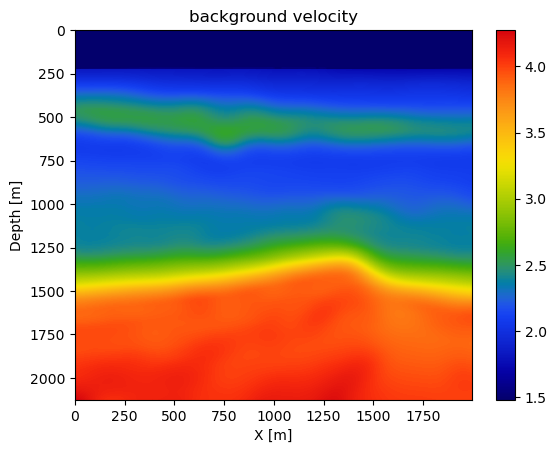

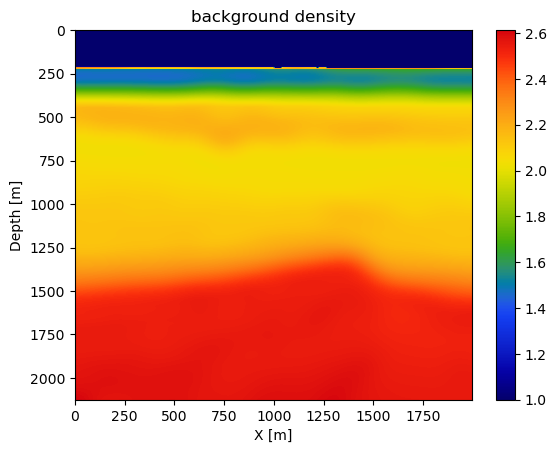

In [8]:
plot_velocity(v0', d; name="background velocity"); colorbar();
plot_velocity(rho0', d; name="background density"); colorbar();

We aim to recover the impedance perturbation at each vintage, which is the difference between true impedance and background impedance

In [9]:
imp0 = v0 .* rho0
dimp_stack = [imp0-imp_stack[i] for i = 1:length(imp_stack)];

These impedance perturbations are shown below

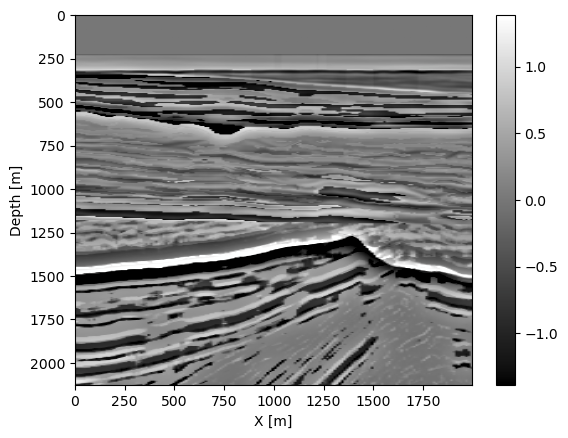

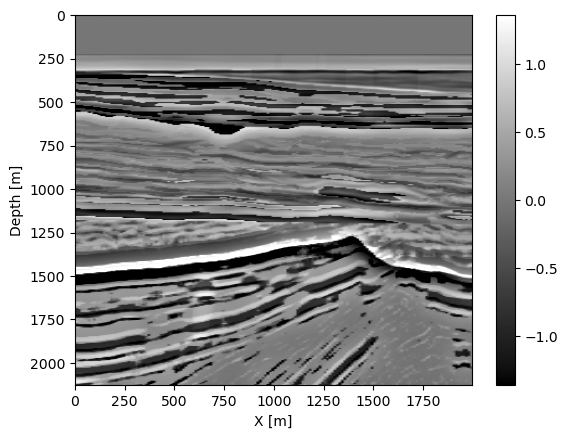

In [10]:
for i = 1:nv
    plot_simage(dimp_stack[i]', d; name=""); colorbar();
end

We are further interested in their difference, which indicates the CO2 plume location

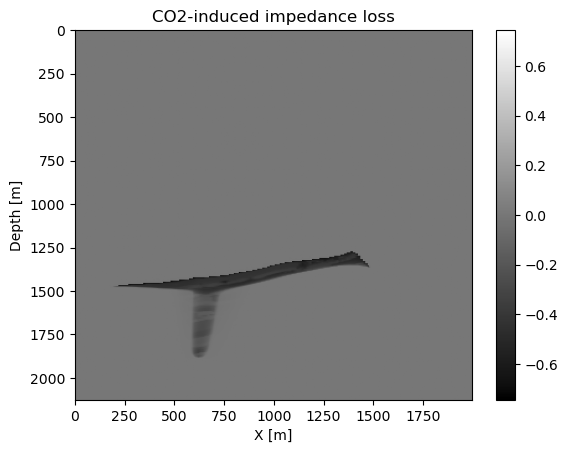

In [11]:
plot_simage(dimp_stack[1]'-dimp_stack[end]', d; name="CO2-induced impedance loss", perc=100); colorbar();

Next, we will set up the seismic acquistion geometry and generate time-lapse data. We first set the number of sources and receivers used in each vintage.

In [12]:
nsrc = 4;
nrec = 200;

We assume receivers are located at the ocean bottom and fixed. Sources are near the ocean surface.

In [13]:
# extent of the model
extentx = (n[1]-1)*d[1];
extentz = (n[2]-1)*d[2];

# source locations
xsrc = range(d[1],stop=(n[1]-1)*d[1],length=nsrc)
ysrc = range(0f0,stop=0f0,length=nsrc)
zsrc = range(10f0,stop=10f0,length=nsrc)

# receiver locations
xrec = range(d[1],stop=(n[1]-1)*d[1], length=nrec)
yrec = 0f0
zrec = range((idx_wb-1)*d[2]-2f0,stop=(idx_wb-1)*d[2]-2f0,length=nrec)

# recording time
timeR = 1800f0
dtR = 4f0
ntR = Int(floor(timeR/dtR))+1

# set up geometries
srcGeometry = Geometry(convertToCell(xsrc), convertToCell(ysrc), convertToCell(zsrc); dt=dtR, t=timeR)
recGeometry = Geometry(xrec, yrec, zrec; dt=dtR, t=timeR, nsrc=nsrc);

set up source wavelet

In [14]:
f0 = 0.024f0     # kHz
wavelet = ricker_wavelet(timeR, dtR, f0)
q = judiVector(srcGeometry, wavelet);

set up the background model

In [15]:
model0 = Model(n, d, o, m0; rho=rho0, nb=80);

set up computational info

In [16]:
ntComp = get_computational_nt(srcGeometry, recGeometry, model0)
info = Info(prod(n), nsrc, ntComp);

set up the modeling linear operators

In [21]:
opt = Options(isic=true, optimal_checkpointing=true)
Pr = judiProjection(info, recGeometry)   # receiver restriction
Ps = judiProjection(info, srcGeometry)   # source injection
F0 = Pr*judiModeling(info, model0; options=opt)*Ps'
J = judiJacobian(F0, q);

Then we can generate the linear data via `J`

In [22]:
@time dlin_stack = [J * vec(dimp_stack[i]) for i = 1:nv];

 52.897184 seconds (28.31 M allocations: 1.700 GiB, 6.52% gc time, 19.06% compilation time)


Operator `born` ran in 1.48 s
Operator `born` ran in 2.85 s
Operator `born` ran in 1.82 s
Operator `born` ran in 1.19 s
Operator `born` ran in 1.36 s
Operator `born` ran in 1.27 s
Operator `born` ran in 1.23 s
Operator `born` ran in 1.29 s


Let's then plot a shot record from baseline and monitor, and their difference

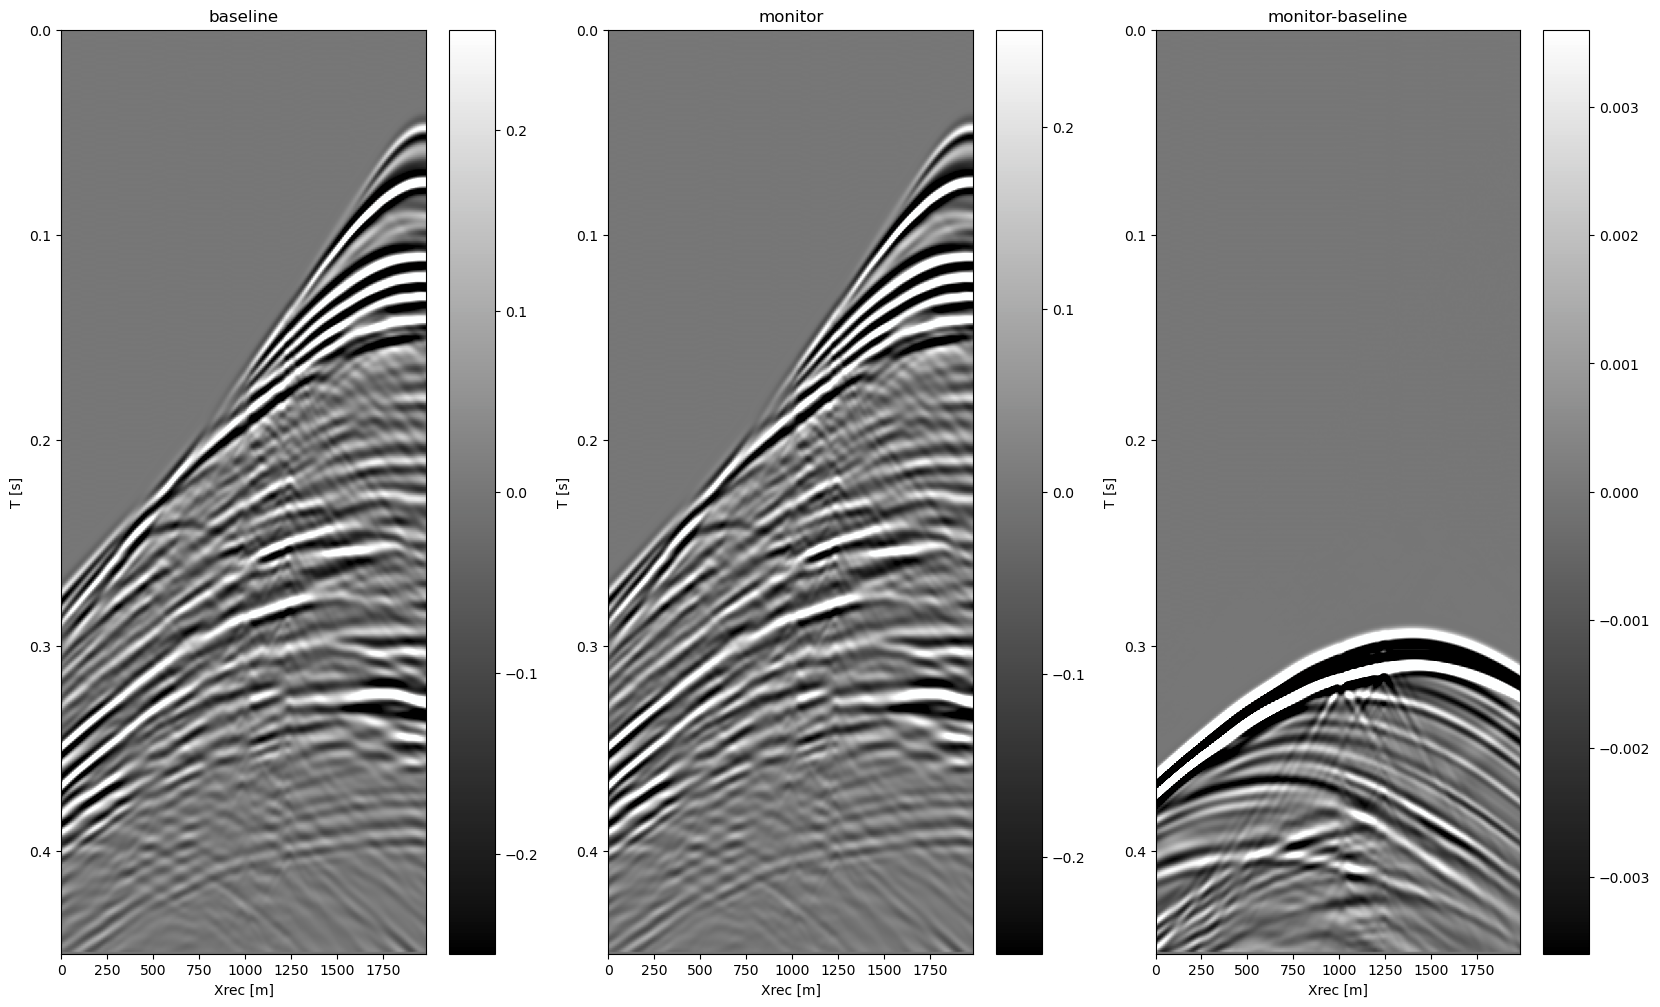

In [26]:
figure(figsize=(20,12));
subplot(1,3,1)
plot_sdata(dlin_stack[1].data[4], (1f-3,extentx/nrec); name="baseline", new_fig=false);colorbar();
subplot(1,3,2)
plot_sdata(dlin_stack[2].data[4], (1f-3,extentx/nrec); name="monitor", new_fig=false);colorbar();
subplot(1,3,3)
plot_sdata((dlin_stack[2].data[4]-dlin_stack[1].data[4]), (1f-3,extentx/nrec); name="monitor-baseline", new_fig=false);colorbar();

We can see the time-lapse mainly comes from the later arrival. Let's then do reverse time migration on these shot records.

In [24]:
@time rtm_stack = [J' * dlin_stack[i] for i = 1:nv];

342.343792 seconds (13.24 M allocations: 772.883 MiB, 0.91% gc time, 1.04% compilation time)


let's then plot the seismic images for baseline and monitor, and their differences

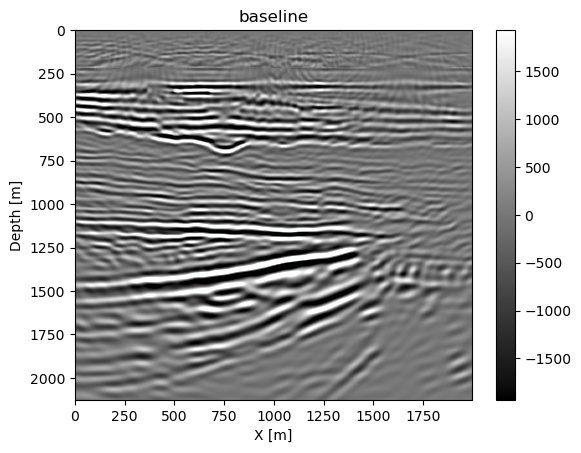

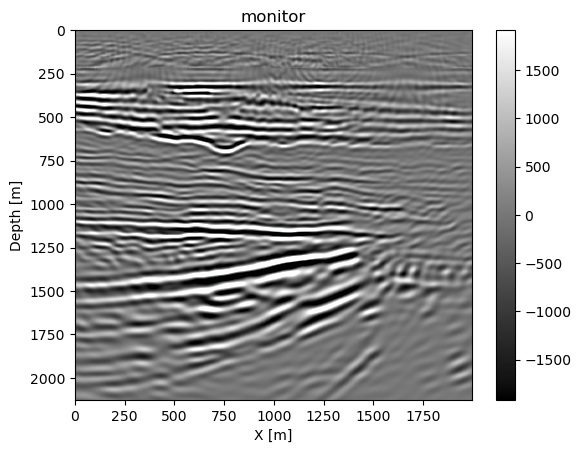

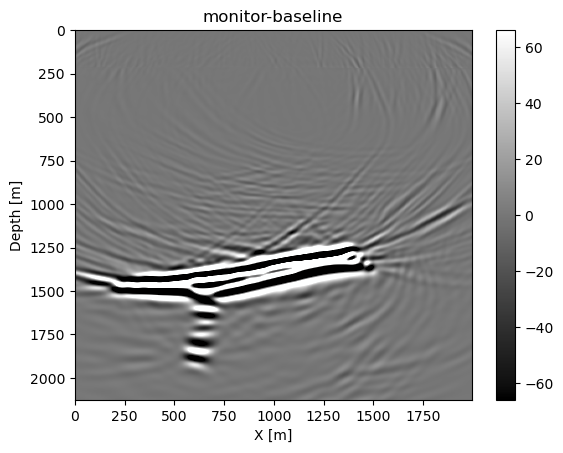

In [33]:
plot_simage(rtm_stack[1].data', d; d_scale=1, name="baseline");colorbar();
plot_simage(rtm_stack[2].data', d; d_scale=1, name="monitor");colorbar();
plot_simage(rtm_stack[2].data'-rtm_stack[1].data', d; d_scale=1, name="monitor-baseline");colorbar();